In [1]:
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
import metpy
from netCDF4 import Dataset
from datetime import datetime

from metpy.units import units
import metpy.calc as mpcalc
import scipy.ndimage as ndimage

import custom_cbars

In [2]:
def plot_map(shapefolder, grid_spc=20, extent=[-85., -30., -60., 15.]):
    """
    
    """
    
    # Set the projection information
    proj = ccrs.PlateCarree(central_longitude=-57.5)
    trans = ccrs.PlateCarree()
    # Create a figure with an axes object on which we will plot
    # Pass the projection to that axes
    fig, ax = plt.subplots(figsize=(5,6), subplot_kw=dict(projection=proj))

    # Zoom in
    ax.set_extent(extent, crs=trans)

    # Add map features
    ax.add_geometries(shpreader.Reader(shapefolder + 'estadosl_2007').geometries(), trans, linewidth=0.3, facecolor='none', edgecolor='darkslategray')
    ax.add_geometries(shpreader.Reader(shapefolder + 'ne_10m_admin_0_countries').geometries(), trans, linewidth=0.5, facecolor='none', edgecolor='darkslategray')

    # Add lat/lon gridlines every 10° to the map
    gl = ax.gridlines(crs=trans, xlocs=np.arange(-180, 181, grid_spc), ylocs=np.arange(-80, 90, grid_spc), draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    return fig, ax, trans

In [3]:
def plot_surface_and_jets(data, ftype='N', shrink=1, asp=20, **kwargs):
    """
    
    """
    
    # Extracting data
    lat = data['latitude']
    lon = data['longitude'] - 180
    date = np.datetime_as_string(data['time'].values, unit='s').partition('T')[0]
    time = np.datetime_as_string(data['time'].values, unit='s').partition('T')[2]

    # Calculating and smoothing fields
    wind = mpcalc.wind_speed(data['u'].sel(level=250), data['v'].sel(level=250))
    wind = ndimage.gaussian_filter(wind, sigma=3, order=0)
    z = data['z'].sel(level=1000)/9.81
    mslp = z/8 + 1000
    mslp = ndimage.gaussian_filter(mslp, sigma=3, order=0)
    thick = (data['z'].sel(level=500) - data['z'].sel(level=1000))/9.81/10
    thick = ndimage.gaussian_filter(thick, sigma=3, order=0)

    # Starting plot
    fig, ax, trans = plot_map(**kwargs)
    
    # - MSLP
    mslp_cont = ax.contour(lon, lat, mslp, levels=np.arange(950, 1050, 4), colors='k', linewidths=1, zorder=3, transform=trans)
    plt.clabel(mslp_cont, np.arange(950, 1050, 4), inline=True, fmt='%1i', fontsize=9, use_clabeltext=True)

    # - Thickness
    thick_levs = (np.arange(0, 540, 6),
                  np.array([540]),
                  np.arange(546, 700, 6))
    thick_colors = ('tab:blue', 'b', 'tab:red')
    for lev, color in zip(thick_levs, thick_colors):
        th_cont = ax.contour(lon, lat, thick, colors=color, levels=lev, linewidths=1, linestyles='dashed', zorder=2, transform=trans)
        plt.clabel(th_cont, lev, inline=True, fmt='%1i', fontsize=9, use_clabeltext=True)

    # - Wind
    contour = ax.contourf(lon, lat, wind, levels=np.arange(0, 120, 10), zorder=1, transform=trans, cmap='wind')
    cb = fig.colorbar(contour, aspect=asp, spacing='uniform', label='250 hPa Wind Speed (m/s)', shrink=shrink, pad=0.025)

    plt.title('MSLP (hPa), 1000-500hPa Thickness (dam)\n' + date + ' ' + time + ' UTC',
              weight='bold', stretch='condensed', size='large', position=(0.55, 1))

    # Saving
    plt.savefig('figures/ERA5_' + ftype + '_sfc-jets_' + date.replace('-', '') + time.replace(':', '')[:-2] + '.png', dpi=300, transparent=True, bbox_inches='tight')

In [4]:
def plot_vort_omega_shear(data, ftype='N', shrink=1, asp=20, **kwargs):
    """
    
    """
    
    # Extracting data
    lat = data['latitude']
    lon = data['longitude'] - 180
    date = np.datetime_as_string(data['time'].values, unit='s').partition('T')[0]
    time = np.datetime_as_string(data['time'].values, unit='s').partition('T')[2]

    # Calculating and smoothing fields
    u_1000 = data['u'].sel(level=1000)
    v_1000 = data['v'].sel(level=1000)
    u_1000 = ndimage.gaussian_filter(u_1000, sigma=3, order=0)
    v_1000 = ndimage.gaussian_filter(v_1000, sigma=3, order=0)
    u_500 = data['u'].sel(level=500)
    v_500 = data['v'].sel(level=500)
    u_500 = ndimage.gaussian_filter(u_500, sigma=3, order=0)
    v_500 = ndimage.gaussian_filter(v_500, sigma=3, order=0)
    z = data['z'].sel(level=500)/9.81/10
    z = ndimage.gaussian_filter(z, sigma=3, order=0)
    vo = data['vo'].sel(level=500)*1e5
    vo = ndimage.gaussian_filter(vo, sigma=3, order=0)
    w = data['w'].sel(level=700)/100*1e3
    w = ndimage.gaussian_filter(w, sigma=3, order=0)
    q = data['q'].sel(level=850)*1e3
    q = ndimage.gaussian_filter(q, sigma=3, order=0)
    
    # Starting plot
    fig, ax, trans = plot_map(**kwargs)
    
    # - Geopotential height
    z_cont = ax.contour(lon, lat, z, levels=np.arange(500, 600, 6), colors='k', linewidths=1, zorder=3, transform=trans)
    plt.clabel(z_cont, np.arange(500, 600, 6), inline=True, fmt='%1i', fontsize=9, use_clabeltext=True)

    # - Omega
#     w_cont = ax.contour(lon, lat, w, levels=np.arange(5, 50, 5), colors='red', linewidths=0.5, zorder=2, transform=trans)


    # - Wind shear
    ax.barbs(lon, lat, u_500 - u_1000, v_500 - v_1000, regrid_shape=15, zorder=4, transform=trans, length=5, linewidth=0.5, flip_barb=True)
    
    # - Vorticity
#     contour = ax.contourf(lon, lat, vo, levels=np.arange(-40, 4, 5), zorder=1, transform=trans, cmap='vorticity')
#     cb = fig.colorbar(contour, aspect=30, spacing='uniform', label='500 hPa Relative Vorticity ($10^{-5} s^{-1}$)', shrink=0.97, pad=0.025)

    # - Specific humidity
    contour = ax.contourf(lon, lat, q, levels=np.arange(0, 22, 2), zorder=1, transform=trans, cmap='vorticity')
    cb = fig.colorbar(contour, aspect=asp, spacing='uniform', label='850 hPa Specific Humidity (g/kg)', shrink=shrink, pad=0.025)

    plt.title('500hPa Geopotential Height (dam)\n1000-500hPa Wind Shear (kt)\n' + date + ' ' + time + ' UTC',
              weight='bold', stretch='condensed', size='large', position=(0.55, 1))

    # Saving
    plt.savefig('figures/ERA5_' + ftype + '_vort-shear_' + date.replace('-', '') + time.replace(':', '')[:-2] + '.png', dpi=300, transparent=True, bbox_inches='tight')

In [11]:
filename = "../Data/REANALYSIS/ERA5/era5_plevs_20170314.nc"

# extent = [-85., -30., -60., 15.]  # [min lon, max lon, min lat, max lat]
# fig_type = 'SA'
# grid_spacing = 10
# cbar_shk = 0.97
# cbar_asp = 30

extent = [-54., -43., -27., -18.]  # [min lon, max lon, min lat, max lat]
fig_type = 'SP-BR'
grid_spacing = 2
cbar_shk = 0.575
cbar_asp = 20

shapefile = '../Data/GENERAL/shapefiles/'

In [21]:
ds = xr.open_dataset("../Data/REANALYSIS/ERA5/era5_sfc_20170314.nc")
print(ds['cin'].values)

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

In [12]:
ds = xr.open_dataset(filename)
print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 721, level: 10, longitude: 1440, time: 24)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 10 100 250 500 700 850 925 950 975 1000
  * time       (time) datetime64[ns] 2017-03-14 ... 2017-03-14T23:00:00
Data variables:
    pv         (time, level, latitude, longitude) float32 ...
    crwc       (time, level, latitude, longitude) float32 ...
    cswc       (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
    d          (time, level, latitude, longitude) float32 ...
    u          (time, level, l

/home/camila/anaconda3/envs/meteo_py3/lib/python3.7/site-packages/cartopy/vector_transform.py:138: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)


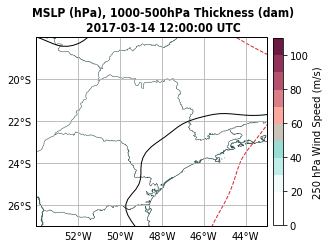

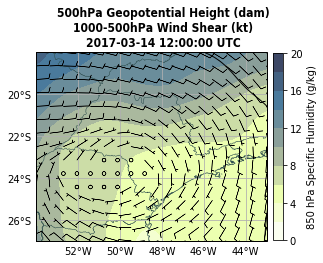

In [13]:
sub_ds = ds.isel(time=12)

plot_surface_and_jets(sub_ds, fig_type, shrink=cbar_shk, asp=cbar_asp, grid_spc=grid_spacing, shapefolder=shapefile, extent=extent)
plot_vort_omega_shear(sub_ds, fig_type, shrink=cbar_shk, asp=cbar_asp, grid_spc=grid_spacing, shapefolder=shapefile, extent=extent)

In [22]:
ds.data_vars.variables

Frozen(OrderedDict([('pv', <xarray.Variable (time: 24, level: 10, latitude: 721, longitude: 1440)>
[249177600 values with dtype=float32]
Attributes:
    units:      K m**2 kg**-1 s**-1
    long_name:  Potential vorticity), ('crwc', <xarray.Variable (time: 24, level: 10, latitude: 721, longitude: 1440)>
[249177600 values with dtype=float32]
Attributes:
    units:      kg kg**-1
    long_name:  Specific rain water content), ('cswc', <xarray.Variable (time: 24, level: 10, latitude: 721, longitude: 1440)>
[249177600 values with dtype=float32]
Attributes:
    units:      kg kg**-1
    long_name:  Specific snow water content), ('z', <xarray.Variable (time: 24, level: 10, latitude: 721, longitude: 1440)>
[249177600 values with dtype=float32]
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential), ('t', <xarray.Variable (time: 24, level: 10, latitude: 721, longitude: 1440)>
[249177600 values with dtype=float32]
Attributes:
    units:      

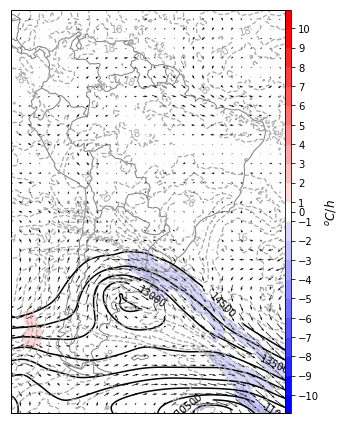

In [21]:
extent_sa = [-85., -30., -60., 15.] #-- [min lon, min lat, max lon, max lat]
fig_type = 'SA'

datacrs = ccrs.PlateCarree()
plotcrs = ccrs.PlateCarree(central_longitude=-50)

fig = plt.figure(figsize=(5,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, .02], left=.07, right=.9, hspace=0.01, 
                       wspace=0.01)

ax = plt.subplot(gs[0], projection=plotcrs)
ax.set_extent(extent_sa)
fig.set_facecolor('w')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')

clev850 = np.arange(10000, 15000, 500)
cs = ax.contour(lon_2d, lat_2d, z_850, clev850, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

clevtemp850 = np.arange(-20, 30, 2)
cs2 = ax.contour(lon_2d, lat_2d, t[12][5].to(units('degC')), clevtemp850,
                 colors='darkgrey', linewidths=1.25, linestyles='dashed', transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

cint = np.arange(-10, 11)
cf = ax.contourf(lon_2d[:][1:-1], lat_2d[:][1:-1], adv_t_850.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='bwr', transform=datacrs)
cax = plt.subplot(gs[1])
cb = plt.colorbar(cf, cax=cax, orientation='vertical', extendrect=True, ticks=cint)
cb.set_label(r'Advection ($^{o}C/h$)', size='large')

ax.quiver(lon_2d, lat_2d, u[12][5].magnitude, v[12][5].magnitude,
          regrid_shape=30, pivot='middle', transform=datacrs)

gs.tight_layout(fig)

In [12]:
t = ds.variables['t'][:].squeeze() * units.kelvin
u = ds.variables['u'][:].squeeze() * units('m/s')
v = ds.variables['v'][:].squeeze() * units('m/s')
z = ds.variables['z'][:].squeeze() * units.meter
lat = ds.variables['latitude'][:].squeeze() #* units.degree
lon = (ds.variables['longitude'][:].squeeze() - 180) #* units.degree
time = ds.variables['time'][:].squeeze()

lon_2d, lat_2d = np.meshgrid(lon, lat)

MemoryError: 

In [11]:
t

<xarray.Variable (time: 24, level: 10, latitude: 721, longitude: 1440)>
array([[[[226.55928, ..., 226.55928],
         ...,
         [223.61221, ..., 223.61221]],

        ...,

        [[248.13899, ..., 248.13899],
         ...,
         [245.01543, ..., 245.01543]]],


       ...,


       [[[226.42383, ..., 226.42383],
         ...,
         [223.7456 , ..., 223.7456 ]],

        ...,

        [[247.35298, ..., 247.35298],
         ...,
         [243.33461, ..., 243.33461]]]], dtype=float32)

In [6]:
#-- Calculating fields
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
dy *= -1

adv_t_850 = mpcalc.advection(t[12][5], [u[12][5], v[12][5]], (dx, dy), dim_order='yx')
adv_t_850 = adv_t_850[:][1:-1]
z_850 = ndimage.gaussian_filter(z[12][5], sigma=3, order=0) * units.meter
adv_t_850 = ndimage.gaussian_filter(adv_t_850, sigma=3, order=0) * units('K/sec')

TypeError: invalid indexer array, does not have integer dtype: array(None, dtype=object)

In [5]:
ds = Dataset("../Data/REANALYSIS/ERA5/era5_20170314.nc")
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2018-08-01 10:58:18 GMT by grib_to_netcdf-2.8.0: grib_to_netcdf /data/data05/scratch/12/d4/_mars-atls18-a82bacafb5c306db76464bc7e824bb75-dtWMJ7.grib -o /data/data03/scratch/5b/e4/_grib2netcdf-atls19-98f536083ae965b31b0d04811be6f4c6-r0HjMW.nc -utime
    dimensions(sizes): longitude(1440), latitude(721), level(10), time(24)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 level(level), int32 time(time), int16 pv(time,level,latitude,longitude), int16 crwc(time,level,latitude,longitude), int16 cswc(time,level,latitude,longitude), int16 z(time,level,latitude,longitude), int16 t(time,level,latitude,longitude), int16 q(time,level,latitude,longitude), int16 w(time,level,latitude,longitude), int16 vo(time,level,latitude,longitude), int16 d(time,level,latitude,longitude), int16 u(time,level,latitude,longitude), int16 